In [1]:
import numpy as np
import cupy as cp
import opticaldevicelib_1d as od_1d
import matplotlib.pyplot as plt
# od_1d.OpticalDevice.init_values(new_dx=1e-9, new_Nx=2**20, gpu_use=True)
od_1d.OpticalDevice.init_values(new_dx=5e-8, new_Nx=2**10, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=5e-9, new_Nx=2**16, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=0.325e-6, new_Nx=2**10, gpu_use=True)
print(f"мера поля X = {od_1d.OpticalDevice.Nx * od_1d.OpticalDevice.dx * 1e6} мкм")

GPU is available!
мера поля X = 51.199999999999996 мкм


Полиномы цернике для описания дефекта СПЛ

In [2]:
import numpy as np
from scipy.special import binom
from functools import lru_cache
import matplotlib.pyplot as plt

def nm_to_noll(n, m):
    j = (n*(n+1))//2 + abs(m)
    if m> 0 and n%4 in (0,1): return j
    if m< 0 and n%4 in (2,3): return j
    if m>=0 and n%4 in (2,3): return j+1
    if m<=0 and n%4 in (0,1): return j+1
    assert False


def nm_to_ansi(n, m):
    return (n*(n+2) + m) // 2


def nm_normalization(n, m):
    """the norm of the zernike mode n,m in born/wolf convetion

    i.e. sqrt( \int | z_nm |^2 )
    """
    return np.sqrt((1.+(m==0))/(2.*n+2))


def nm_polynomial(n, m, rho, theta, normed=True):
    """returns the zernike polyonimal by classical n,m enumeration

    if normed=True, then they form an orthonormal system

        \int z_nm z_n'm' = delta_nn' delta_mm'

        and the first modes are

        z_nm(0,0)  = 1/sqrt(pi)*
        z_nm(1,-1) = 1/sqrt(pi)* 2r cos(phi)
        z_nm(1,1)  = 1/sqrt(pi)* 2r sin(phi)
        z_nm(2,0)  = 1/sqrt(pi)* sqrt(3)(2 r^2 - 1)
        ...
        z_nm(4,0)  = 1/sqrt(pi)* sqrt(5)(6 r^4 - 6 r^2 +1)
        ...

    if normed =False, then they follow the Born/Wolf convention
        (i.e. min/max is always -1/1)

        \int z_nm z_n'm' = (1.+(m==0))/(2*n+2) delta_nn' delta_mm'

        z_nm(0,0)  = 1
        z_nm(1,-1) = r cos(phi)
        z_nm(1,1)  =  r sin(phi)
        z_nm(2,0)  = (2 r^2 - 1)
        ...
        z_nm(4,0)  = (6 r^4 - 6 r^2 +1)


    """
    if abs(m) > n:
        raise ValueError(" |m| <= n ! ( %s <= %s)" % (m, n))

    if (n - m) % 2 == 1:
        return 0 * rho + 0 * theta

    radial = 0
    m0 = abs(m)

    for k in range((n - m0) // 2 + 1):
        radial += (-1.) ** k * binom(n - k, k) * binom(n - 2 * k, (n - m0) // 2 - k) * rho ** (n - 2 * k)

    radial *= (rho <= 1.)

    if normed:
        prefac = 1. / nm_normalization(n, m)
    else:
        prefac = 1.
    if m >= 0:
        return prefac * radial * np.cos(m0 * theta)
    else:
        return prefac * radial * np.sin(m0 * theta)


@lru_cache(maxsize=32)
def rho_theta(size):
    r = np.linspace(-1,1,size)
    X,Y = np.meshgrid(r,r, indexing='ij')
    rho = np.hypot(X,Y)
    theta = np.arctan2(Y,X)
    return rho, theta


@lru_cache(maxsize=32)
def outside_mask(size):
    rho, theta = rho_theta(size)
    return nm_polynomial(0, 0, rho, theta, normed=False) < 1


def dict_to_list(kv):
    max_key = max(kv.keys())
    out = [0]*(max_key+1)
    for k,v in kv.items():
        out[k] = v
    return out


def ensure_dict(values, order):
    if isinstance(values,dict):
        return values
    if isinstance(values,np.ndarray):
        values = tuple(values.ravel())
    if isinstance(values,(tuple,list)):
        order = str(order).lower()
        order in ('noll','ansi') or print("Could not identify the Zernike nomenclature/order")
        offset = 1 if order=='noll' else 0
        indices = range(offset,offset+len(values))
        return dict(zip(indices,values))
    raise ValueError("Could not identify the data type for dictionary formation")



class Zernike:

    """
        Encapsulates Zernike polynomials

        :param index: string, integer or tuple, index of Zernike polynomial e.g. 'defocus', 4, (2,2)
        :param oder: string, defines the Zernike nomenclature if index is an integer, eg noll or ansi, default is noll
    """

    _ansi_names = ['piston', 'tilt', 'tip', 'oblique astigmatism', 'defocus',
                   'vertical astigmatism', 'vertical trefoil', 'vertical coma',
                   'horizontal coma', 'oblique trefoil', 'oblique quadrafoil',
                   'oblique secondary astigmatism', 'primary spherical',
                   'vertical secondary astigmatism', 'vertical quadrafoil']
    _nm_pairs = set((n,m) for n in range(200) for m in range(-n,n+1,2))
    _noll_to_nm = dict(zip((nm_to_noll(*nm) for nm in _nm_pairs),_nm_pairs))
    _ansi_to_nm = dict(zip((nm_to_ansi(*nm) for nm in _nm_pairs),_nm_pairs))

    def __init__(self, index, order='noll'):
        super().__setattr__('_mutable', True)
        if isinstance(index,str):
            if index.isdigit():
                index = int(index)
            else:
                name = index.lower()
                name in self._ansi_names or print("Your input for index is string : Could not identify the name of Zernike polynomial")
                index = self._ansi_names.index(name)
                order = 'ansi'

        if isinstance(index,(list,tuple)) and len(index)==2:
            self.n, self.m = int(index[0]), int(index[1])
            (self.n, self.m) in self._nm_pairs or print("Your input for index is list/tuple : Could not identify the n,m order of Zernike polynomial")
        elif isinstance(index,int):
            order = str(order).lower()
            order in ('noll','ansi') or print("Your input for index is int : Could not identify the Zernike nomenclature/order")
            if order == 'noll':
                index in self._noll_to_nm or print("Your input for index is int and input for Zernike nomenclature is Noll: Could not identify the Zernike polynomial with this index")
                self.n, self.m = self._noll_to_nm[index]
            elif order == 'ansi':
                index in self._ansi_to_nm or print("Your input for index is int and input for Zernike nomenclature is ANSI: Could not identify the Zernike polynomial with this index")
                self.n, self.m = self._ansi_to_nm[index]
        else:
            raise ValueError("Could not identify your index input, we accept strings, lists and tuples only")

        self.index_noll = nm_to_noll(self.n, self.m)
        self.index_ansi = nm_to_ansi(self.n, self.m)
        self.name = self._ansi_names[self.index_ansi] if self.index_ansi < len(self._ansi_names) else None
        self._mutable = False


    def polynomial(self, size, normed=True, outside=np.nan):
        
        """
            For visualization of Zernike polynomial on a disc of unit radius

            :param size: integer, Defines the shape of square grid, e.g. 256 or 512
            :param normed: boolen, Whether the Zernike polynomials are normalized, default is True
            :param outside: scalar, Outside padding of the spherical disc defined within a square grid, default is np.nan
            :return: 2D array, Zernike polynomial computed on a disc of unit radius defined within a square grid  
        """

        np.isscalar(size) and int(size) > 0 or print("error size")
        return self.phase(*rho_theta(int(size)), normed=normed, outside=outside)


    def polynomial_vertical(self, size, normed=True, outside=np.nan):  # added by srio
        np.isscalar(size) and int(size) > 0 or print("error size")

        rho = np.linspace(-1.0,1.0,size)
        w = nm_polynomial(self.n, self.m, rho, 0.0, normed=bool(normed))
        if outside is not None:
            w[nm_polynomial(0, 0, rho, 0.0, normed=False) < 1] = outside
        return w

    def phase(self, rho, theta, normed=True, outside=None):

        """
            For creation of a Zernike polynomial  with a given polar co-ordinate system

            :param rho: 2D square array,  radial axis
            :param theta: 2D square array, azimuthal axis
            :param normed: boolen, whether the Zernike polynomials are normalized, default is True
            :param outside: scalar, outside padding of the spherical disc defined within a square grid, default is None
            :return: 2D array, Zernike polynomial computed for rho and theta
        """
        (isinstance(rho,np.ndarray) and rho.ndim==2 and rho.shape[0]==rho.shape[1]) or print('Only 2D square array for radial co-ordinate is accepted')
        (isinstance(theta,np.ndarray) and theta.shape==rho.shape) or print('Only 2D square array for azimutha co-ordinate is accepted')
        size = rho.shape[0]
        np.isscalar(normed) or print("error")
        outside is None or np.isscalar(outside) or print("Only scalar constant value for outside is accepted")
        w = nm_polynomial(self.n, self.m, rho, theta, normed=bool(normed))
        if outside is not None:
            w[nm_polynomial(0, 0, rho, theta, normed=False) < 1] = outside 

        return w


    def __hash__(self):
        return hash((self.n,self.m))


    def __eq__(self, other):
        return isinstance(other,Zernike) and (self.n,self.m) == (other.n,other.m)


    def __lt__(self, other):
        return self.index_ansi < other.index_ansi


    def __setattr__(self, *args):
        if self._mutable:
            super().__setattr__(*args)
        else:
            raise AttributeError('Zernike is immutable')


    def __repr__(self):
        return f'Zernike(n={self.n}, m={self.m: 1}, noll={self.index_noll:2}, ansi={self.index_ansi:2}' + (f", name='{self.name}')" if self.name is not None else ")")

<>:20: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:20: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
C:\Users\mamich\AppData\Local\Temp\ipykernel_6392\3382580193.py:20: SyntaxWarning: invalid escape sequence '\i'
  """the norm of the zernike mode n,m in born/wolf convetion
C:\Users\mamich\AppData\Local\Temp\ipykernel_6392\3382580193.py:28: SyntaxWarning: invalid escape sequence '\i'
  """returns the zernike polyonimal by classical n,m enumeration


In [3]:
def create_1d_zernike_basis(size=512, noll=[6, 8, 10, 11, 12, 14, 22, 37], width=2.0, filename=None, do_plot=True):

    nnoll = len(noll)

    basis = np.zeros((size, len(noll)))
    basis_x = np.linspace(-0.5*width, 0.5*width, size)
    for i in range(len(noll)):
        z = Zernike(noll[i], order='noll')
        w = z.polynomial_vertical(size)
        basis[:, i] = w

    if do_plot: plt.plot(basis_x, basis)

    if filename is not None:  # write to file
        f = open(filename, 'w')
        for i in range(size):
            f.write("%g  " % (basis_x[i]))
            for j in range(nnoll):
                f.write("%12.10f  " % (basis[i, j]))
            f.write("\n")
        f.close()
        print("File %s written to disk." % filename)

    return basis_x, basis

# basis_x, basis = create_1d_zernike_basis()

In [7]:
def create_1d_zernike_sampled_profiles(nsamples,
                    noll=[6, 8, 10, 11, 12, 14, 22, 37],
                    distrubution=['n','n','n','n','n','n','n','n'],
                    scale=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                    size=128,
                    factor=1.0,
                    seed=69,
                    do_plot=True):

    Y = np.zeros((size, nsamples))
    C = np.zeros((len(noll), nsamples))

    rg = np.random.default_rng(seed)
    x = np.linspace(-1, 1, size)

    # noll       = [6,     8,  10,  11,  12,  14,  22, 37]
    # distrubution = ['n', 'n', 'n', 'u', 'n', 'n', 'u', 'u']
    # scale        = [0.5, 0.5, 0.5, 2.3, .05, .05, 1.0, 0.5]

    for i in range(nsamples):
        y = np.zeros_like(x)

        for ij, j in enumerate(noll):
            z = Zernike(j, order='noll')

            if distrubution[ij] == 'n':
                c = rg.normal(loc=0, scale=scale[ij] * factor)
            elif distrubution[ij] == 'u':
                c = rg.uniform(-scale[ij] * factor, scale[ij] * factor)
            else:
                raise Exception("Why am I here?")

            # if j <= 10:
            #     # Z5 (Zcoeffs[4]) to Z10 (Zcoeffs[9]) are more important and have a higher weight
            #     c = rg.normal(loc=0, scale=0.5 * factor)
            # elif j == 11:
            #     # Spherical aberration 1st order (Z11)
            #     c = rg.uniform(-2.3 * factor, 2.3 * factor)
            # elif j >= 12 and j <= 21:
            #     # Z12 (Zcoeffs[11]) to Z21 (Zcoeffs[20]) and Z23 (Zcoeffs[22]) to Z36 (Zcoeffs[35]) are very low
            #     c = rg.normal(loc=0, scale=0.05 * factor)
            # elif j == 22:
            #     # Spherical aberration 2nd order (Z22)
            #     c = rg.uniform(-1. * factor, 1. * factor)
            # elif j == 37:
            #     # Spherical aberration 3nd order (Z37)
            #     c = rg.uniform(-0.5 * factor, 0.5 * factor)
            # else:
            #     raise Exception("Why am I here?")

            w = z.polynomial_vertical(size)
            y += c * w
            C[ij, i] = c
        Y[:, i] = y

        if do_plot: plt.plot(x, y)

    return C, Y

# create_1d_zernike_sampled_profiles(nsamples=100)

(1024, 2000) (7, 2000)
[[ 7.64694176e-09 -7.52794284e-09  1.79804946e-08 ...  4.22070563e-08
  -1.49486402e-08  8.16075933e-09]
 [-9.84717336e-08 -9.41504664e-08 -2.86026962e-08 ...  1.28438201e-07
   8.99416175e-08 -3.05477356e-09]
 [-7.09232681e-08 -8.82016956e-08 -1.63545185e-08 ...  1.77240584e-07
  -3.10642649e-09 -7.65937944e-08]
 ...
 [ 2.19030008e-08 -1.44377873e-08 -7.39294142e-09 ...  7.98572048e-08
   5.97540944e-08 -3.02973792e-09]
 [-6.36751313e-09  8.16587628e-08  9.24162514e-08 ... -1.92341269e-07
   2.83529129e-08  5.71925239e-08]
 [ 7.22853972e-08  7.90121377e-08  5.44048438e-08 ... -1.75610965e-07
  -4.13700690e-08  2.69324190e-08]]


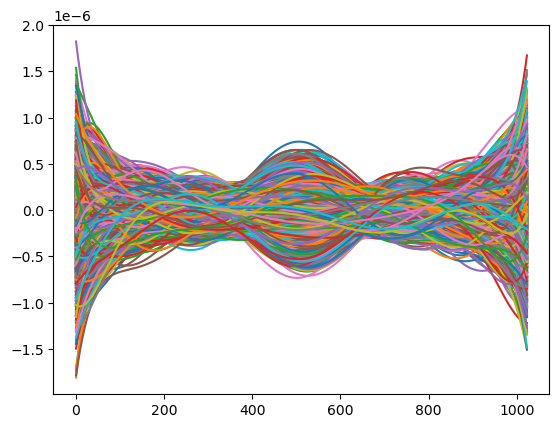

In [8]:
# calculate zernike basis
basis_x, basis_pre = create_1d_zernike_basis(
    size=od_1d.OpticalDevice.Nx,
    noll=[6,   8,  10,  11,  14,  22, 37],  # removed 12!!!!!!!!!!!!!!!!!!
    filename=None,
    width=od_1d.OpticalDevice.dx*od_1d.OpticalDevice.Nx,
    do_plot=False)


# orthonormalize (Gram Schmidt)
basis, R = np.linalg.qr(basis_pre)


# create sampled profiles
size = basis_x.size
nsamples = 2000
seed = 691999  # seed for generation of the random Zernike profiles

noll = [6, 8, 10, 11, 14, 22, 37]  # removed 12!!!!!!!!!!!!!!!!!!
distrubution = ['u', 'u', 'u', 'u', 'n', 'u', 'u']
scale = np.ones(shape=7) * 1e-7

C, Y  = create_1d_zernike_sampled_profiles(
    nsamples, size=size,
    noll=noll, distrubution=distrubution, 
    scale=scale, factor=1.0,
    seed=seed, do_plot=0,)

print(Y.shape, C.shape)
xx = np.linspace(-od_1d.OpticalDevice.dx*od_1d.OpticalDevice.Nx/2, od_1d.OpticalDevice.dx*od_1d.OpticalDevice.Nx/2,size)

# Gram-Schmidt normalization
Rinv = np.linalg.inv(R)

# fit sampled profiles
F = np.zeros_like(C)
for i in range(nsamples):
    F[:,i] = np.dot(R, C[:,i])

Y = Y.T
C = C.T

plt.plot(Y.T)
print(C)

 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w = (128,)
 w =

(array([[ 0.71430984, -0.08141232,  1.10892122, -0.15094136,  0.46781012,
          2.16450194,  0.68397721, -0.05984505,  0.17867918, -0.31893659,
          0.7264825 ,  0.17745952,  0.97704036,  0.40681613, -0.30815083,
          0.35787085,  1.8076796 ,  0.88967538, -0.60105343,  1.009414  ,
          1.20390274,  0.90681601,  0.07941121, -0.32513951,  1.08111396,
          0.84601073,  0.82032024,  0.57879825, -0.38690319, -1.48162774,
         -0.11639402, -0.30803968, -0.16935155, -0.11213502, -1.28099757,
          0.63308262, -0.19724894, -0.29004462, -2.20830048, -0.47895038,
          0.11749501, -1.59500586, -0.16637909, -1.78668188, -1.68312136,
         -0.50295474,  1.70193055, -0.41417275, -1.27136901, -0.2326748 ,
         -0.29071814,  0.793555  ,  1.34435626, -0.02534401,  0.13977402,
         -0.42716819, -0.29977496,  0.44373809,  1.91671417, -0.94854322,
          0.53912122,  0.43261711,  0.60167016,  1.47398649, -0.02625601,
         -1.968705  ,  0.17907371, -0.

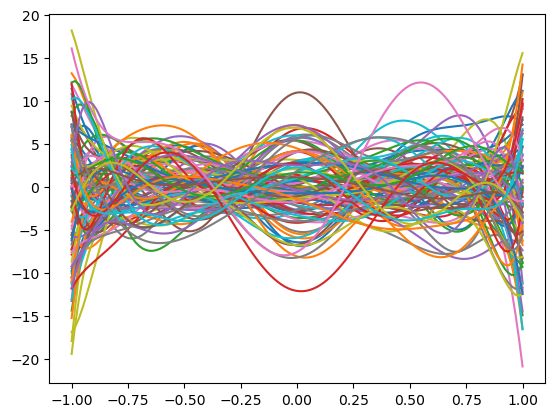

In [20]:
def create_1d_zernike_sampled_profiles(nsamples,
                    noll=[6, 8, 10, 11, 12, 14, 22, 37],
                    distrubution=['n','n','n','n','n','n','n','n'],
                    scale=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                    size=128,
                    factor=1.0,
                    seed=69,
                    do_plot=True):

    Y = np.zeros((size, nsamples))
    C = np.zeros((len(noll), nsamples))

    rg = np.random.default_rng(seed)
    x = np.linspace(-1, 1, size)

    # noll       = [6,     8,  10,  11,  12,  14,  22, 37]
    # distrubution = ['n', 'n', 'n', 'u', 'n', 'n', 'u', 'u']
    # scale        = [0.5, 0.5, 0.5, 2.3, .05, .05, 1.0, 0.5]

    for i in range(nsamples):
        y = np.zeros_like(x)

        for ij, j in enumerate(noll):
            z = Zernike(j, order='noll')

            if distrubution[ij] == 'n':
                c = rg.normal(loc=0, scale=scale[ij] * factor)
            elif distrubution[ij] == 'u':
                c = rg.uniform(-scale[ij] * factor, scale[ij] * factor)
            else:
                raise Exception("Why am I here?")

            # if j <= 10:
            #     # Z5 (Zcoeffs[4]) to Z10 (Zcoeffs[9]) are more important and have a higher weight
            #     c = rg.normal(loc=0, scale=0.5 * factor)
            # elif j == 11:
            #     # Spherical aberration 1st order (Z11)
            #     c = rg.uniform(-2.3 * factor, 2.3 * factor)
            # elif j >= 12 and j <= 21:
            #     # Z12 (Zcoeffs[11]) to Z21 (Zcoeffs[20]) and Z23 (Zcoeffs[22]) to Z36 (Zcoeffs[35]) are very low
            #     c = rg.normal(loc=0, scale=0.05 * factor)
            # elif j == 22:
            #     # Spherical aberration 2nd order (Z22)
            #     c = rg.uniform(-1. * factor, 1. * factor)
            # elif j == 37:
            #     # Spherical aberration 3nd order (Z37)
            #     c = rg.uniform(-0.5 * factor, 0.5 * factor)
            # else:
            #     raise Exception("Why am I here?")
            
            w = z.polynomial_vertical(size)
            print(f" w = {w.shape}")
            y += c * w
            C[ij, i] = c
        Y[:, i] = y

        if do_plot: plt.plot(x, y)

    return C, Y

create_1d_zernike_sampled_profiles(nsamples=100)

In [35]:
def zernike_polinom(noll=[6, 8, 10, 11, 14, 22, 37],
                    size=128,
                    c=[1, 1, 1, 1, 1, 1, 1],
                    do_plot=True):


    x = np.linspace(-1, 1, size)


    y = np.zeros_like(x)

    for ij, j in enumerate(noll):
        z = Zernike(j, order='noll')

        w = z.polynomial_vertical(size)
        y += c[ij] * w
        # C[ij, i] = c

    if do_plot: plt.plot(x, y)

    return y

array([-2.03100304, -1.98794086, -1.94582433, ..., -0.84375918,
       -0.88226483, -0.92170762])

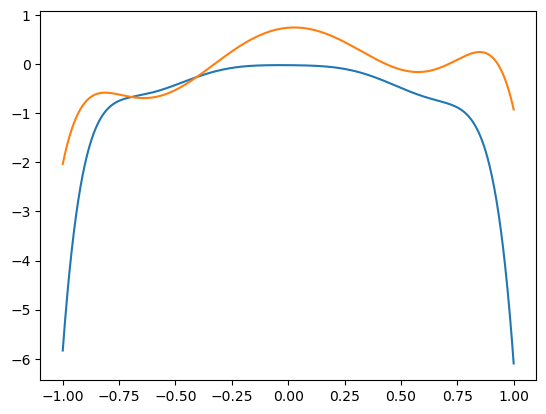

In [36]:
zernike_polinom(c=[ 0.09755304,  0.00633113, -0.05305856, -0.2907733,  -1.3206491,  -0.37975374, -0.12424533], size=basis_x.size)
zernike_polinom(c=[ 0.04782274, -0.06515919,  0.26125677,  0.0851566,  -0.32512022, -0.24758957, -0.03357725], size=basis_x.size)

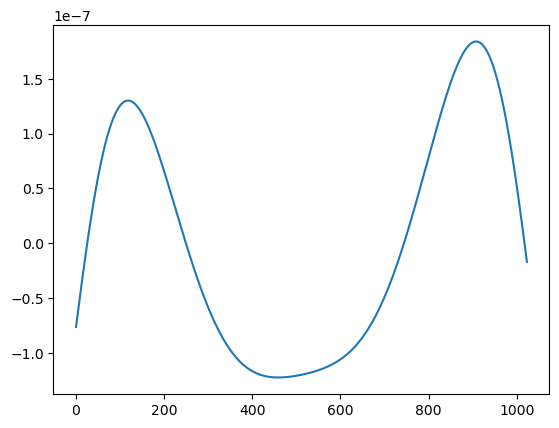

In [ ]:
[ 0.04782274 -0.06515919  0.26125677  0.0851566  -0.32512022 -0.24758957
 -0.03357725]

Оптическая схема с СПЛ с дефектами

In [6]:
"""Инициализация точечного источника"""
p = od_1d.PointSource(z=15, x0=0, En=12) 
E_ps1 = np.ones_like(p.E())

"""Параметры СПЛ"""
N_gl = 26
Copy_flag = True
A = 50e-6
R = 6.25e-6
d = 2e-6
mol = "Si"
dens = 2.33

"""Инициализация СПЛ"""
crl_ideal = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens)

crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

focus = crl_ideal.focus()

print(f"фокусное расстояние = {focus * 1e3 :.3f} мм")


фокусное расстояние = 34.634 мм


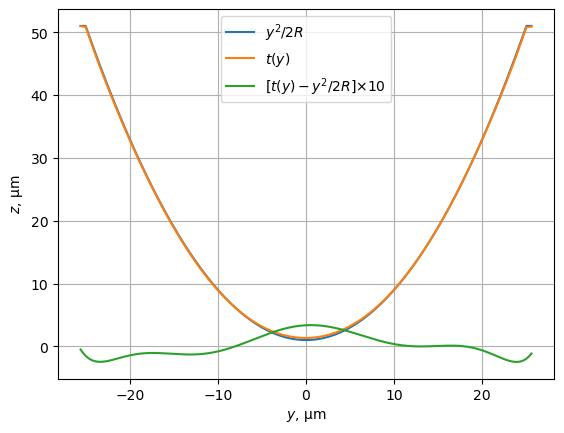

In [7]:
# %matplotlib widget
"""Построение профиля поверхности СПЛ"""
# I_prop = abs(crl.image_prop(z0=5, z1=focus, N_lens=N_gl)) ** 2
T_ideal = crl_ideal.T().get() * 1e6
# T_m = crl_m.T().get() * 1e6
xxx = p.x.get() * 1e6

distor = Y[8] * 1e6
# distor[abs(xxx)>25] = 0

T_m = T_ideal + distor


def norm_pdf(x, sig, mean, coef):
    # coef = 1/(sig*cp.sqrt(2*cp.pi))
    # coef = 0.1
    return -coef * cp.exp(-(x-mean)**2/(2*sig**2)) + 1


arr_gauss = norm_pdf(p.x, sig=3e-6, mean=0, coef=0.4).get() 

# plt.plot(p.x.get()*1e6, ( crl_ideal.T() / crl_ideal.toplogy()).get(), label='parabola / T(x)')


plt.plot(xxx, T_ideal, label=r"${y}^2/2R$")
plt.plot(xxx, T_m, label=r"$t(y)$")
# plt.plot(p.x.get()*1e6, arr_gauss*10, label='mult. by this gaussian')

plt.plot(xxx, (T_m - T_ideal)*10, label=r"$[t(y)-{y}^2/2R$]×10")
# plt.plot(xxx, -np.exp(-(xxx+4)**2/(2*(1.5)**2)))

# plt.plot(p.x.get()*1e6, dif_curv  , label="ellips")
# plt.plot(p.x.get()*1e6, , label="eq")
# plt.plot(p.x.get()*1e6, crl_curv.T().get(), label='ellips')
# plt.plot(p.x.get()*1e6, crl_eq.T().get(), label='equidist')
# plt.plot(p.x.get()*1e6, h.T().get(), label='equidist')
plt.legend()
# plt.yscale("log")
plt.xlabel("$y$, μm")
plt.ylabel("$z$, μm");
plt.grid()
# plt.ylim(-3, 10)
# plt.xlim(-10, 10);

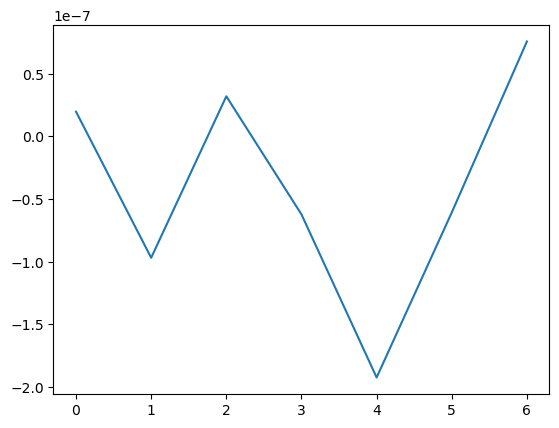

In [8]:
plt.plot(C[7])

100%|██████████| 25/25 [00:00<00:00, 3156.65it/s]

 dz = 17.36620375251125 mm 
 dx = 0.0 μm 
 fwhm = 0.18080983171578535 μm 
 I_max = 46.511714680160836 rel. un. 
 div_ang = 0.00032054516932000787


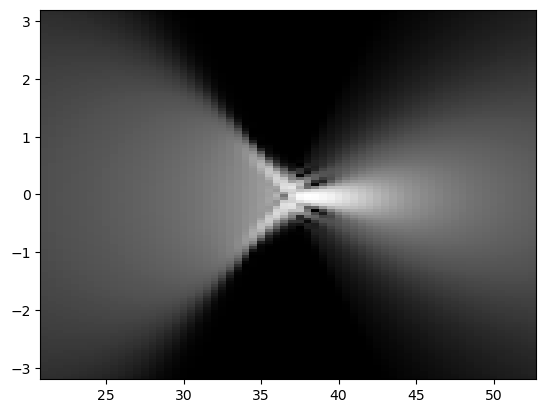

In [9]:
"""Точечный источник"""
z_arr = np.arange(19, 51, 0.5) * 1e-3
# z_arr = np.array([focus])
I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
     = crl_m.focus_params(z_arr, T_arr=cp.array(T_m)*1e-6, n_cut=64, focus=34e-3)

print(f" dz = {(5e-2+dz_max_1*1e-3-crl_m.focus())*1e3} mm \n dx = {dx_max} μm \n fwhm = {fwhm*1e6} μm \n I_max = {I_max} rel. un. \n div_ang = {div_ang}")
I_sum_dot = abs(focus_images)**2
I_sum_dot = I_sum_dot.get()

plt.pcolormesh(z_arr*1e3+2, x_cutted*1e6, np.log1p(I_sum_dot.T), cmap="Greys_r")
# plt.ylim(-8, 10)
# plt.xticks(np.arange((z_arr*1e3+2)[0], (z_arr*1e3+2)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [11]:
from tqdm import tqdm

In [19]:
"Протяженный источник"
crl_m.set_z(z=focus)
I_arr_test = crl_m.I()
z_arr = np.arange(19, 51, 0.5) * 1e-3

N_source_x = 21
size_source_x = cp.linspace(-2e-4, 2e-4, N_source_x)


def gauss_1d(x, sig):
    return np.exp(-0.5*(x/sig)**2)

gauss_test = cp.zeros(shape=(N_source_x))

sig = 1.17e-4 / 2.355

# sh1, sh2 = I_arr_test.shape
sh_z = len(z_arr)
I_sum = cp.zeros(shape=I_sum_dot.shape)
# I_sum_ideal = cp.zeros(shape=I_sum_dot.shape)

# phase_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
# phase_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# t_loop = crl_global.T()

xxx = p.x.get() * 1e6

Y = cp.array(Y)
# t_loop = cp.array(T_ideal)

# N_frame = 8000

i_start = 1000
i_end = 2000
I_data = cp.empty(shape=(i_end-i_start, len(z_arr), 128))


for i in tqdm(range(i_start, i_end)):
    # print(f"---FRAME № {i}---")
    distor = Y[i]
    # distor[abs(xxx)>25] = 0
    t_loop = cp.array(T_ideal) * 1e-6 + distor
    I_sum = cp.zeros(shape=I_sum_dot.shape)
    for j, x0 in enumerate(size_source_x):
        p_loop = od_1d.PointSource(En=12, z=15, x0=x0)
        E_p_loop = p_loop.E()

        crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                        copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

        gauss_test[j] = gauss_1d(x0, sig)
            
        I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
            = crl_loop.focus_params(z_arr, T_arr=t_loop, n_cut=64, focus=34e-3)
        
        I_sum += abs(focus_images)**2 * gauss_test[j] / N_source_x
    I_data[i-i_start] = I_sum
    

# cp.save("I_data", I_data)
# np.save("target_data", C)

    # I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
    #     = crl_loop_ideal.focus_params(z_arr, n_cut=int(20e-6/od_1d.OpticalDevice.dx), focus=34e-3)
    # I_sum_ideal += abs(focus_images)**2 * gauss_test[j] / N_source_x

# I_sum = I_sum.get()
# I_sum_ideal = I_sum_ideal.get()

# print(I_sum.flatten().shape)

100%|██████████| 1000/1000 [53:10<00:00,  3.19s/it]


In [20]:
I_1000 = np.load("I_data.npy")
I_1000_2000 = I_data.get()
I_2000 = np.concatenate([I_1000, I_1000_2000])
cp.save("I_2000", I_2000)
np.save("target_2000", C)

In [ ]:
np.save("X", C)

In [ ]:
C.shape

In [ ]:
Y.shape

In [ ]:
plt.pcolormesh(I_data[0].get())

In [ ]:
21*320

In [ ]:
plt.plot(size_source_x.get()*1e6, gauss_test.get())

In [ ]:
320*21

In [ ]:
plt.pcolormesh(z_arr*1e3, x_cutted*1e6, I_sum.T, cmap="CMRmap")
# plt.ylim(-10, 10)
plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [ ]:
plt.plot(I_sum[9])

In [ ]:
from scipy.interpolate import interp1d

def interpolate_image(image, target_width):
  """
  Интерполирует изображение с ширины 1024 пикселей до target_width пикселей.

  Аргументы:
    image: numpy массив с формой (21, 1024), представляющий изображение.
    target_width: Целевая ширина изображения (в данном случае 256).

  Возвращает:
    numpy массив с формой (21, target_width), представляющий интерполированное изображение.
  """

  # Создаем массив x-координат для исходного изображения
  x = np.linspace(0, 1, image.shape[1])  # От 0 до 1, 1024 точки

  # Создаем массив x-координат для интерполированного изображения
  x_new = np.linspace(0, 1, target_width)  # От 0 до 1, target_width точки

  # Инициализируем массив для интерполированного изображения
  interpolated_image = np.zeros((image.shape[0], target_width))

  # Интерполируем каждую строку изображения
  for i in range(image.shape[0]):
    # Создаем функцию интерполяции для текущей строки
    f = interp1d(x, image[i, :], kind='linear')  # Линейная интерполяция

    # Интерполируем строку
    interpolated_image[i, :] = f(x_new)

  return interpolated_image

In [ ]:
plt.pcolormesh(interpolate_image(I_sum, 1024).T, cmap="CMRmap")
# plt.ylim(-10, 10)
# plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));